In [1]:
%matplotlib inline
from itertools import product as c_product
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model

from disp import set_font_size
from lin_fit import fit_h


EXPT = 'CL_360_LOWFLOW_ACV'
# EXPT = 'CL_180_HighFlow_ACV'

TARGS = ['G2', 'G3', 'G4', 'G5']
SRCS = ['Odor', 'AbsHeading', 'ForVel']
NORMED_COLS = ['G2', 'G3', 'G4', 'G5', 'ForVel', 'AngVel', 'AbsAngVel', 'Heading', 'AbsHeading']

T_WDW = [-4.5, 4.5]  # must be symmetric to ensure correct convolution
TRUNCATE = 5  # num timepoints to truncate for edge effects

T_WDW_OTA = [-10., 10.]  # time window for odor-triggered avg
VARS_OTA = [
    'G2', 'G3', 'G4', 'G5',
    'DFF0G2', 'DFF0G3', 'DFF0G4', 'DFF0G5',
    'AbsHeading', 'DeltaAbsHeading',
    'ForVel', 'DeltaForVel'
]

DT = 0.1
T_WDW_TR = [DT * (int(T_WDW[0]/DT) + TRUNCATE), DT * (int(T_WDW[1]/DT) - TRUNCATE)]

DATA_DIR = os.path.join('data', EXPT)
SAVE_DIR = os.path.join('data_', '_RESULTS', 'ODOR_TRACKING')

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

# Load data and normalize

In [2]:
base = 'clean.csv'
mvng = 'moving.csv'
mvng_cols = ['Start', 'Stop']
odor = 'odor_times.csv'
odor_cols = ['Odor_On', 'Odor_Off', 'Include']

data_u = {}  # unnormalized data
data_n = {}  # normalized data
d_mvng = {}  # dfs of moving times
d_odor = {}  # dfs of odor times

for fly in os.listdir(DATA_DIR):
    fly_path = os.path.join(DATA_DIR, fly)
    
    for trial in os.listdir(fly_path):
        trial_path = os.path.join(fly_path, trial)
        
        # load data
        data_u_ = pd.read_csv(os.path.join(trial_path, base))
        
        # store relevant columns
        data_u_ = data_u_[['Time', 'G2_avg', 'G3_avg', 'G4_avg', 'G5_avg', 'ForVel', 'AngVel', 'Heading']]
        data_u_['AbsAngVel'] = np.abs(data_u_['AngVel'])
        data_u_['AbsHeading'] = np.abs(data_u_['Heading'])
        
        # make odor mask
        df_odor = pd.read_csv(os.path.join(trial_path, odor))
        odor_mask = np.zeros(len(data_u_['Time']), dtype=bool)
        starts = df_odor[odor_cols[0]]
        stops = df_odor[odor_cols[1]]
        
        for start, stop in zip(starts, stops):
            odor_mask[(start <= data_u_['Time']) & (data_u_['Time'] < stop)] = True
            
        data_u_['Odor'] = odor_mask.astype(float)
        
        # make moving mask
        df_mvng = pd.read_csv(os.path.join(trial_path, mvng))
        mvng_mask = np.zeros(len(data_u_['Time']), dtype=bool)
        starts = df_mvng[mvng_cols[0]]
        stops = df_mvng[mvng_cols[1]]
        
        for start, stop in zip(starts, stops):
            mvng_mask[(start <= data_u_['Time']) & (data_u_['Time'] < stop)] = True
            
        data_u_['Mvng'] = mvng_mask
        
        data_u_ = data_u_.rename(columns={'G2_avg': 'G2', 'G3_avg': 'G3', 'G4_avg': 'G4', 'G5_avg': 'G5'})
        
        # normalize data
        data_n_ = data_u_.copy()
        data_n_[NORMED_COLS] -= data_n_[NORMED_COLS].mean()
        data_n_[NORMED_COLS] /= data_n_[NORMED_COLS].std()
        
        # store all results
        data_u[trial] = data_u_
        data_n[trial] = data_n_
        d_mvng[trial] = df_mvng
        d_odor[trial] = df_odor

# Trial-by-trial odor and heading filters

## Fit filters

In [3]:
mode = 'FULL'

# create initial filter dataframes
t_h = np.arange(*T_WDW, DT)
df_blank = pd.DataFrame(
    np.nan, index=sorted(list(data_n)),
    columns=(['N', 'R2'] + list(t_h[TRUNCATE:-TRUNCATE]))).rename_axis('TRIAL')

filters = {'{}_FROM_{}'.format(targ, src.upper()): df_blank.copy() for targ, src in c_product(TARGS, SRCS)}

# set up discrete windows over which to define filter
wdws_d = [None, None]
wdws_d[0] = int(round(T_WDW[0]/DT))
wdws_d[1] = wdws_d[0] + int(len(t_h))

# loop over trials
for trial, data_n_ in data_n.items():
    
    # loop over srcs & targs
    for src in SRCS:
        for targ in TARGS:
            # set up data
            xs = {src: np.array(data_n_[src])}
            y = np.array(data_n_[targ])
            
            # fit filter
            hs, icpt, y_hat, r2 = fit_h(
                xs, y, {src: wdws_d}, [src], 'built-in', params={'model': linear_model.LinearRegression})
            
            n = np.sum(~np.isnan(y_hat))
            
            # store filter
            filters['{}_FROM_{}'.format(targ, src.upper())].loc[trial] = [n, r2] + list(hs[src][TRUNCATE:-TRUNCATE])

# save all filters
for k, df_save in filters.items():
    fn = '{}_FILTERS_{}_T_WDW_{}_{}_{}.csv'.format(EXPT, k, *T_WDW_TR, mode)
    df_save.to_csv(os.path.join(SAVE_DIR, fn), na_rep='NaN')

## Plot filters

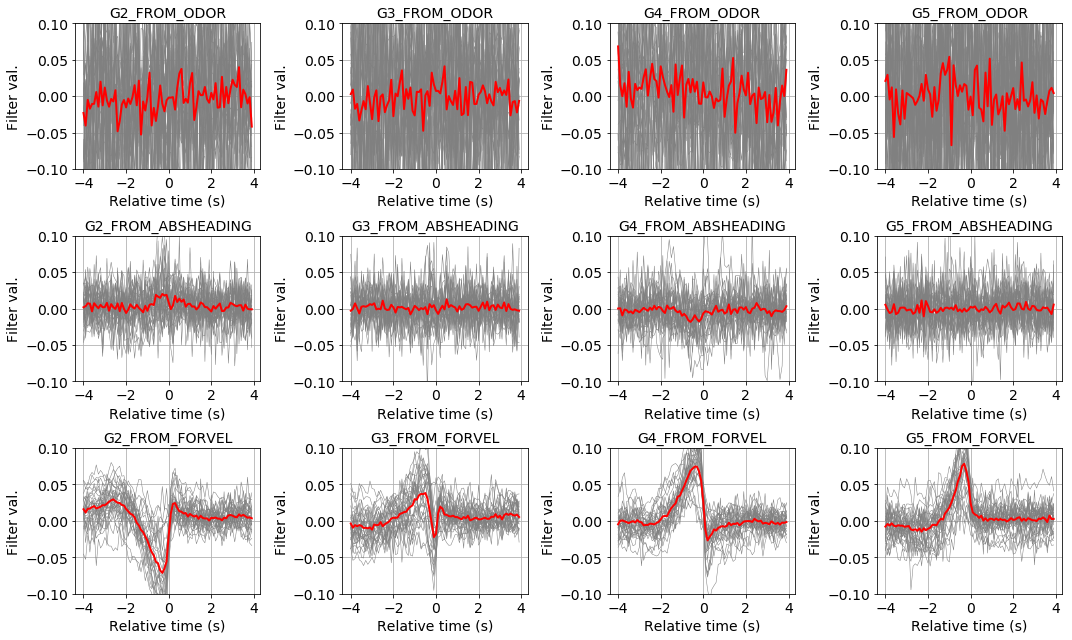

In [4]:
mode = 'FULL'

# plot filters
y_lim = (-.1, .1)
n_xmpls = 30

fig, axs = plt.subplots(len(SRCS), len(TARGS), figsize=(15, 3*len(SRCS)), tight_layout=True)

for src, ax_row in zip(SRCS, axs):
    for targ, ax in zip(TARGS, ax_row):
        k = '{}_FROM_{}'.format(targ, src.upper())
        
        fn = '{}_FILTERS_{}_T_WDW_{}_{}_{}.csv'.format(EXPT, k, *T_WDW_TR, mode)
        
        df = pd.read_csv(os.path.join(SAVE_DIR, fn), index_col=0)
        
        # random trials
        ax.plot(t_h[TRUNCATE:-TRUNCATE], np.array(df.sample(n_xmpls)).T[2:], lw=0.5, color='gray')
        
        # mean
        ax.plot(t_h[TRUNCATE:-TRUNCATE], np.array(df.mean())[2:], lw=2, color='r')
        
        ax.set_ylim(y_lim)
        
        ax.set_xlabel('Relative time (s)')
        ax.set_ylabel('Filter val.')
        ax.set_title(k)
        
        ax.grid()
        set_font_size(ax, 14)
        
fig.savefig(os.path.join(SAVE_DIR, '{}_FILTERS_T_WDW_{}_{}_{}.pdf'.format(EXPT, *T_WDW_TR, mode)))

# Odor-triggered DANs, ForVel, Heading

In [5]:
t_ota = np.arange(*T_WDW_OTA, DT)
wdw_d = [None, None]
wdw_d[0] = int(round(T_WDW_OTA[0]/DT))
wdw_d[1] = wdw_d[0] + len(t_ota)

df_blank = pd.DataFrame(columns=['PulseID', 'Trial', 'PulseCounter', 'Include'] + list(t_ota))

odor_trig = {k.upper(): df_blank.copy() for k in VARS_OTA}

# loop over trials
p_id = 0

for trial, data_u_ in data_u.items():
    # loop over odor pulses
    pulses = d_odor[trial]
    
    starts = pulses[odor_cols[0]]
    stops = pulses[odor_cols[1]]
    includes_binary = pulses[odor_cols[2]]
    includes = ['Include' if x else 'Exclude' for x in includes_binary ]
    
    for ctr, (start, stop, include) in enumerate(zip(starts, stops, includes)):
        # get time window for data selection
        t_idx = int(round(start/DT))
        t_idx_0 = t_idx + wdw_d[0]
        t_idx_1 = t_idx + wdw_d[1]
        
        g2 = data_u_['G2'][t_idx_0:t_idx_1]
        g3 = data_u_['G3'][t_idx_0:t_idx_1]
        g4 = data_u_['G4'][t_idx_0:t_idx_1]
        g5 = data_u_['G5'][t_idx_0:t_idx_1]
        
        for_vel = data_u_['ForVel'][t_idx_0:t_idx_1]
        abs_heading = data_u_['AbsHeading'][t_idx_0:t_idx_1]
        
        odor_trig['G2'].loc[p_id] = [p_id, trial, ctr, include] + list(g2)
        odor_trig['G3'].loc[p_id] = [p_id, trial, ctr, include] + list(g3)
        odor_trig['G4'].loc[p_id] = [p_id, trial, ctr, include] + list(g4)
        odor_trig['G5'].loc[p_id] = [p_id, trial, ctr, include] + list(g5)
        
        odor_trig['FORVEL'].loc[p_id] = [p_id, trial, ctr, include] + list(for_vel)
        odor_trig['ABSHEADING'].loc[p_id] = [p_id, trial, ctr, include] + list(abs_heading)
        
        # get computed data features
        
        ## neural dff/f
        f0_g2 = np.nanmean(g2[t_ota < 0])
        f0_g3 = np.nanmean(g3[t_ota < 0])
        f0_g4 = np.nanmean(g4[t_ota < 0])
        f0_g5 = np.nanmean(g5[t_ota < 0])
        
        dff_g2 = (g2 - f0_g2) / f0_g2
        dff_g3 = (g3 - f0_g3) / f0_g3
        dff_g4 = (g4 - f0_g4) / f0_g4
        dff_g5 = (g5 - f0_g5) / f0_g5
        
        odor_trig['DFF0G2'].loc[p_id] = [p_id, trial, ctr, include] + list(dff_g2)
        odor_trig['DFF0G3'].loc[p_id] = [p_id, trial, ctr, include] + list(dff_g3)
        odor_trig['DFF0G4'].loc[p_id] = [p_id, trial, ctr, include] + list(dff_g4)
        odor_trig['DFF0G5'].loc[p_id] = [p_id, trial, ctr, include] + list(dff_g5)
        
        ## behavior delta
        for_vel_0 = np.nanmean(for_vel[t_ota < 0])
        abs_heading_0 = np.nanmean(abs_heading[t_ota < 0])
        
        delta_for_vel = for_vel - for_vel_0
        delta_abs_heading = abs_heading - abs_heading_0
        
        odor_trig['DELTAFORVEL'].loc[p_id] = [p_id, trial, ctr, include] + list(delta_for_vel)
        odor_trig['DELTAABSHEADING'].loc[p_id] = [p_id, trial, ctr, include] + list(delta_abs_heading)
        
        p_id += 1
        
# save results
for k, df_save in odor_trig.items():
    fn = 'ODOR_TRIG_{}.csv'.format(k)
    df_save.to_csv(os.path.join(SAVE_DIR, fn), na_rep='NaN', index=False)

## Plot odor-triggered DANs

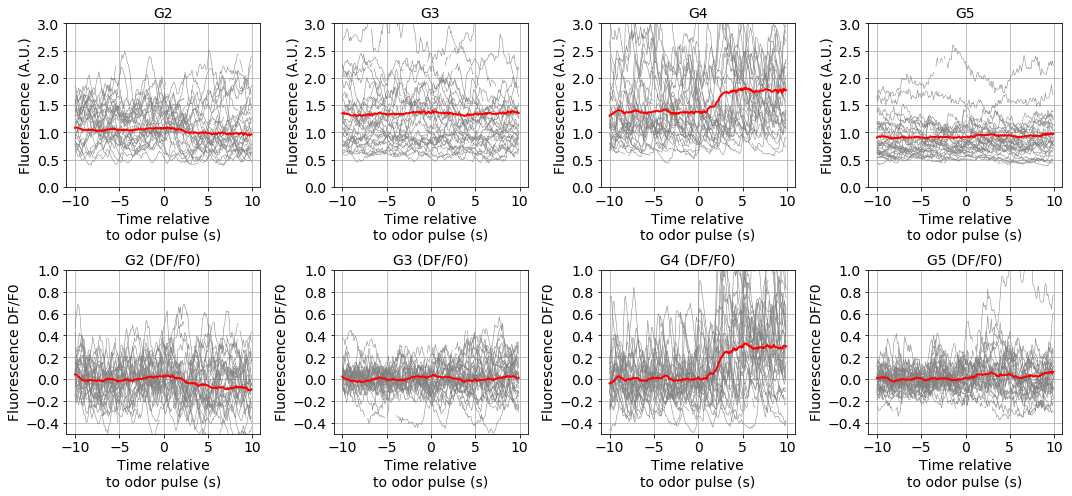

In [6]:
t_ota = np.arange(*T_WDW_OTA, DT)
n_xmpls = 30
y_lims = [(0, 3), (-.5, 1)]

fig, axs = plt.subplots(2, 4, figsize=(15, 7), tight_layout=True)

for ax_col, gx in zip(axs.T, ['G2', 'G3', 'G4', 'G5']):

    # original DAN
    ## open file
    fn = 'ODOR_TRIG_{}.csv'.format(gx)
    df = pd.read_csv(os.path.join(SAVE_DIR, fn), index_col=0)

    ## random trials
    ax_col[0].plot(t_ota, np.array(df.sample(n_xmpls)).T[3:], lw=0.5, color='gray')

    ## mean
    ax_col[0].plot(t_ota, np.array(df.mean())[1:], lw=2, color='r')
    
    ax_col[0].set_ylim(y_lims[0])
    
    ax_col[0].set_xlabel('Time relative\nto odor pulse (s)')
    ax_col[0].set_ylabel('Fluorescence (A.U.)')
    ax_col[0].set_title(gx)
    
    # DF/F0 DANs
    fn = 'ODOR_TRIG_DFF0{}.csv'.format(gx)
    df = pd.read_csv(os.path.join(SAVE_DIR, fn), index_col=0)
    
    ## random trials
    ax_col[1].plot(t_ota, np.array(df.sample(n_xmpls)).T[3:], lw=0.5, color='gray')

    ## mean
    ax_col[1].plot(t_ota, np.array(df.mean())[1:], lw=2, color='r')
    
    ax_col[1].set_ylim(y_lims[1])
    
    ax_col[1].set_xlabel('Time relative\nto odor pulse (s)')
    ax_col[1].set_ylabel('Fluorescence DF/F0')
    ax_col[1].set_title('{} (DF/F0)'.format(gx))
    
for ax in axs.flat:
    ax.grid()
    set_font_size(ax, 14)
    
fig.savefig(os.path.join(SAVE_DIR, '{}_ODOR_TRIG_DAN.pdf'.format(EXPT)))

## Plot odor-triggered ForVel and AbsHeading

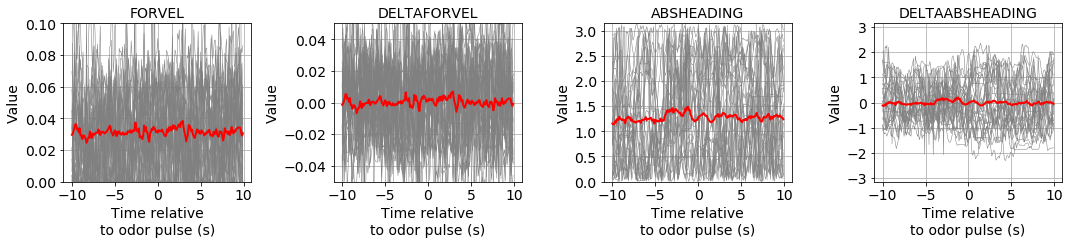

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(15, 3.5), tight_layout=True)
y_lims = [(0, .1), (-.05, .05), (0, 3.14159), (-3.14159, 3.14159)]

sfxs = ['FORVEL', 'DELTAFORVEL', 'ABSHEADING', 'DELTAABSHEADING']

for ax, sfx, y_lim in zip(axs, sfxs, y_lims):
    
    # load data
    fn = 'ODOR_TRIG_{}.csv'.format(sfx)
    df = pd.read_csv(os.path.join(SAVE_DIR, fn), index_col=0)
    
    # random trials
    ax.plot(t_ota, np.array(df.sample(n_xmpls)).T[3:], lw=0.5, color='gray')
    
    # mean
    ax.plot(t_ota, np.array(df.mean())[1:], lw=2, color='r')
    
    ax.set_ylim(y_lim)
    
    ax.set_xlabel('Time relative\nto odor pulse (s)')
    ax.set_ylabel('Value')
    
    ax.set_title(sfx)
    
for ax in axs:
    ax.grid()
    set_font_size(ax, 14)
    
fig.savefig(os.path.join(SAVE_DIR, '{}_ODOR_TRIG_BEHAV.pdf'.format(EXPT)))

# Odor-masked/unmasked DAN-from-AbsHeading filters

## Fit filters

In [8]:
O_WDW = [-10, 10]  # time window to select around odor

# create initial filter dataframes
t_h = np.arange(*T_WDW, DT)
df_blank = pd.DataFrame(
    np.nan, index=sorted(list(data_n)),
    columns=(['N', 'R2'] + list(t_h[TRUNCATE:-TRUNCATE]))).rename_axis('TRIAL')

for mode in ['ODOR', 'NO_ODOR']:

    filters = {'{}_FROM_{}'.format(targ, src.upper()): df_blank.copy() for targ, src in c_product(TARGS, SRCS)}

    # set up discrete windows over which to define filter
    wdws_d = [None, None]
    wdws_d[0] = int(round(T_WDW[0]/DT))
    wdws_d[1] = wdws_d[0] + int(len(t_h))

    # loop over trials
    for trial, data_n_ in data_n.items():

        # make odor mask (true during "odor" times)
        t = data_n_['Time']
        
        starts = d_odor[trial][odor_cols[0]]
        stops = d_odor[trial][odor_cols[1]]
        
        mask = np.zeros(len(data_n_), dtype=bool)
        
        for start, stop in zip(starts, stops):
            mask[(start + O_WDW[0] <= t) & (t < stop + O_WDW[1])] = True
        
        # loop over srcs & targs
        for src in SRCS:
            for targ in TARGS:
                # set up data
                xs = {src: np.array(data_n_[src])}
                y = np.array(data_n_[targ])
                
                # mask out relevant times
                if mode == 'ODOR':
                    y[~mask] = np.nan
                elif mode == 'NO_ODOR':
                    y[mask] = np.nan
                
                # fit filter
                hs, icpt, y_hat, r2 = fit_h(
                    xs, y, {src: wdws_d}, [src], 'built-in', params={'model': linear_model.LinearRegression})

                n = np.sum(~np.isnan(y_hat))

                # store filter
                filters['{}_FROM_{}'.format(targ, src.upper())].loc[trial] = [n, r2] + list(hs[src][TRUNCATE:-TRUNCATE])

    # save all filters
    for k, df_save in filters.items():
        fn = '{}_FILTERS_{}_T_WDW_{}_{}_{}.csv'.format(EXPT, k, *T_WDW_TR, mode)
        df_save.to_csv(os.path.join(SAVE_DIR, fn), na_rep='NaN')

## Make plots

### During odor

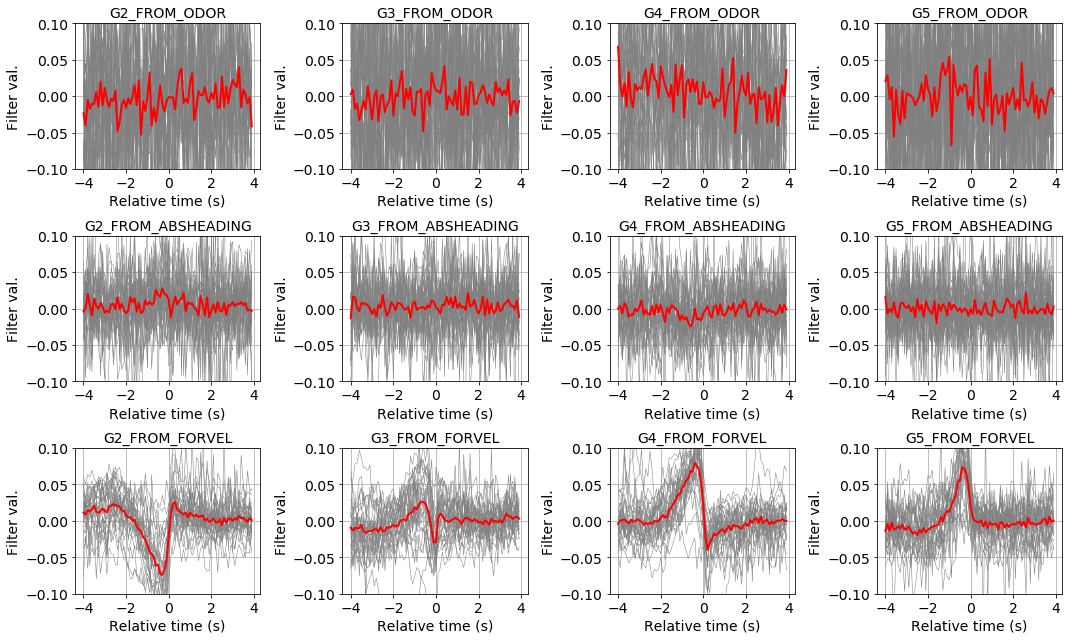

In [9]:
mode = 'ODOR'

# plot filters
y_lim = (-.1, .1)
n_xmpls = 30

fig, axs = plt.subplots(len(SRCS), len(TARGS), figsize=(15, 3*len(SRCS)), tight_layout=True)

for src, ax_row in zip(SRCS, axs):
    for targ, ax in zip(TARGS, ax_row):
        k = '{}_FROM_{}'.format(targ, src.upper())
        
        fn = '{}_FILTERS_{}_T_WDW_{}_{}_{}.csv'.format(EXPT, k, *T_WDW_TR, mode)
        
        df = pd.read_csv(os.path.join(SAVE_DIR, fn), index_col=0)
        
        # random trials
        ax.plot(t_h[TRUNCATE:-TRUNCATE], np.array(df.sample(n_xmpls)).T[2:], lw=0.5, color='gray')
        
        # mean
        ax.plot(t_h[TRUNCATE:-TRUNCATE], np.array(df.mean())[2:], lw=2, color='r')
        
        ax.set_ylim(y_lim)
        
        ax.set_xlabel('Relative time (s)')
        ax.set_ylabel('Filter val.')
        ax.set_title(k)
        
        ax.grid()
        set_font_size(ax, 14)
        
fig.savefig(os.path.join(SAVE_DIR, '{}_FILTERS_T_WDW_{}_{}_{}.pdf'.format(EXPT, *T_WDW_TR, mode)))

### Outside of odor

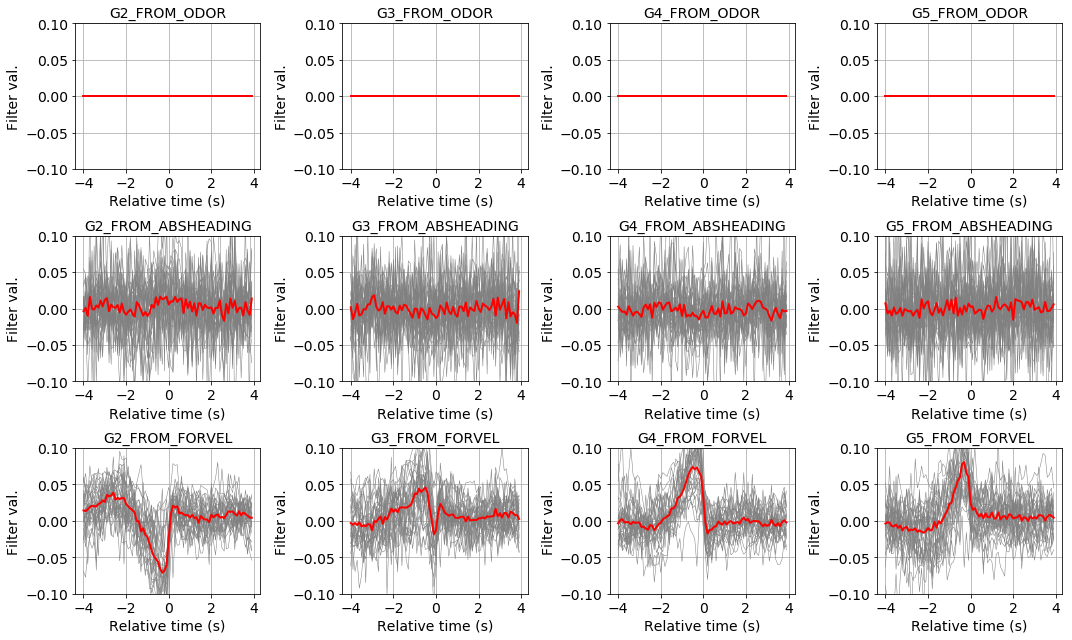

In [10]:
mode = 'NO_ODOR'

# plot filters
y_lim = (-.1, .1)
n_xmpls = 30

fig, axs = plt.subplots(len(SRCS), len(TARGS), figsize=(15, 3*len(SRCS)), tight_layout=True)

for src, ax_row in zip(SRCS, axs):
    for targ, ax in zip(TARGS, ax_row):
        k = '{}_FROM_{}'.format(targ, src.upper())
        
        fn = '{}_FILTERS_{}_T_WDW_{}_{}_{}.csv'.format(EXPT, k, *T_WDW_TR, mode)
        
        df = pd.read_csv(os.path.join(SAVE_DIR, fn), index_col=0)
        
        # random trials
        ax.plot(t_h[TRUNCATE:-TRUNCATE], np.array(df.sample(n_xmpls)).T[2:], lw=0.5, color='gray')
        
        # mean
        ax.plot(t_h[TRUNCATE:-TRUNCATE], np.array(df.mean())[2:], lw=2, color='r')
        
        ax.set_ylim(y_lim)
        
        ax.set_xlabel('Relative time (s)')
        ax.set_ylabel('Filter val.')
        ax.set_title(k)
        
        ax.grid()
        set_font_size(ax, 14)
        
fig.savefig(os.path.join(SAVE_DIR, '{}_FILTERS_T_WDW_{}_{}_{}.pdf'.format(EXPT, *T_WDW_TR, mode)))

# Correlation of odor-triggered G4 and time-varying heading

In [11]:
from scipy import stats


WDW_H = [-10, 10]  # s
WDW_G = (1, 4)  # s
t_r = np.arange(*WDW_H, DT)


def pearsonr_with_confidence(x, y, confidence=0.95):
    """
    Calculate the pearson correlation coefficient, its p-value, and upper and
        lower 95% confidence bound.
    :param x: one array
    :param y: other array
    :param confidence: how confident the confidence interval
    :return: correlation, p-value, lower confidence bound, upper confidence bound
    """

    rho, p = stats.pearsonr(x, y)
    n = len(x)

    # calculate confidence interval on correlation
    # how confident do we want to be?
    n_sds = stats.norm.ppf(1 - (1 - confidence) / 2)
    z = 0.5 * np.log((1 + rho) / (1 - rho))  # convert to z-space
    sd = np.sqrt(1. / (n - 3))
    lb_z = z - n_sds * sd
    ub_z = z + n_sds * sd
    # convert back to rho-space
    lb = (np.exp(2*lb_z) - 1) / (np.exp(2*lb_z) + 1)
    ub = (np.exp(2*ub_z) - 1) / (np.exp(2*ub_z) + 1)

    return rho, p, lb, ub


for gx in ['G2', 'G3', 'G4', 'G5']:

    # get odor-trig neural and delta heading for all odor presentations
    gs = []  # neural time-averaged w/in WDW_G rel to odor onset
    hs = []  # full abs heading time-series w/in WDW_H rel to odor onset
    h_0s = []  # initial headings (t-avg'd over 10 s preceding odor)
    
    ## loop over trials
    for trial, data_u_ in data_u.items():

        t = data_u_['Time']

        # loop over odor presentations
        starts = d_odor[trial][odor_cols[0]]

        for start in starts:

            t_idx_start = int(round(start + WDW_H[0]))
            t_idx_stop = t_idx_start + len(t_r)

            # get neural data
            
            ## original 
            f_ = data_u_[gx][t_idx_start:t_idx_stop]
            
            ## avg initial neural
            f_0 = np.nanmean(f_[t_r < 0])
            
            ## df/f0
            dff0 = (f_ - f_0) / f_0
            
            ## windowed average df/f0
            g = np.nanmean(dff0[(WDW_G[0] <= t_r) & (t_r < WDW_G[1])])

            # get heading
            
            ## total heading
            h_ = np.array(data_u_['AbsHeading'][t_idx_start:t_idx_stop]).flatten()
            
            ## avg initial heading
            h_0 = np.nanmean(h_[t_r < 0])
            
            ## delta heading
            h = (h_ - h_0)

            p_id += 1

            gs.append(g)
            hs.append(h)
            h_0s.append(h_0)

    # compute full
    gs = np.array(gs)
    hs = np.array(hs)
    h_0s = np.array(h_0s)

    rs = []
    ps = []
    lbs = []
    ubs = []

    for t_ctr, h_col in enumerate(hs.T):
        valid = (~np.isnan(gs)) & (~np.isnan(h_col))
        
        r, p, lb, ub = pearsonr_with_confidence(gs[valid], h_col[valid])
        
        rs.append(r)
        ps.append(p)
        lbs.append(lb)
        ubs.append(ub)

    df = pd.DataFrame(columns=['TIME', 'R', 'PVAL', 'CONF_LB', 'CONF_UB'])

    df['TIME'] = t_r
    df['R'] = rs
    df['PVAL'] = ps
    df['CONF_LB'] = lbs
    df['CONF_UB'] = ubs

    df.to_csv(os.path.join(SAVE_DIR, '{}_ODOR_TRIG_TIME_VARY_CORR_{}_{}_{}_ABSHEADING.csv'.format(EXPT, gx, *WDW_G)), index=False)

## Make plots

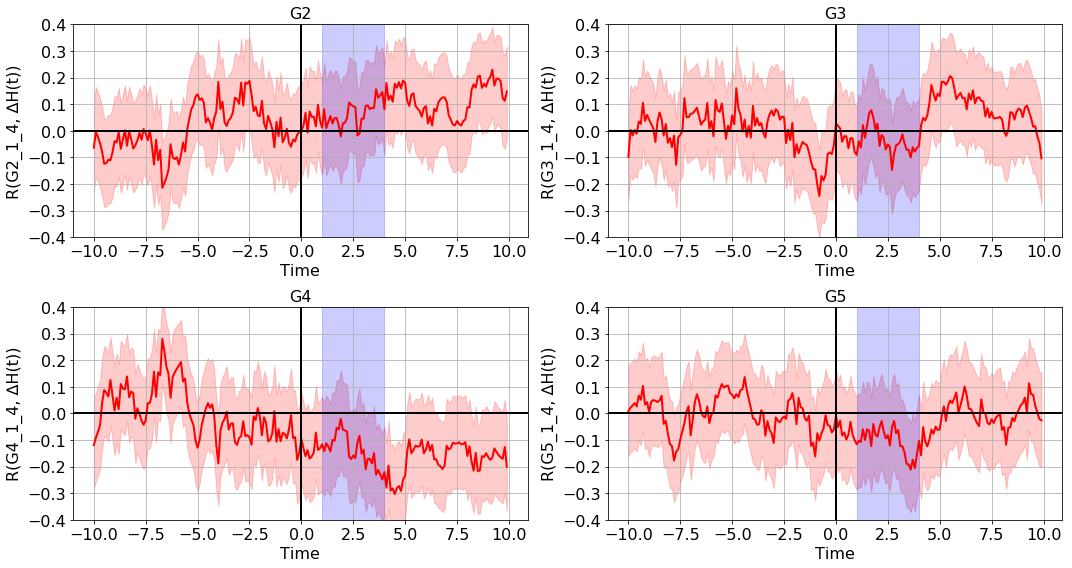

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8), tight_layout=True)
    
for ax, gx in zip(axs.flat, ['G2', 'G3', 'G4', 'G5']):
    # load file
    fn = '{}_ODOR_TRIG_TIME_VARY_CORR_{}_{}_{}_ABSHEADING.csv'.format(EXPT, gx, *WDW_G)
    df = pd.read_csv(os.path.join(SAVE_DIR, fn))

    # correlation
    ax.plot(df['TIME'], df['R'], color='r', lw=2)
    ax.fill_between(df['TIME'], df['CONF_LB'], df['CONF_UB'], color='r', alpha=.2)
    
    ax.axhline(0, lw=2, color='k')
    ax.axvline(0, lw=2, color='k')

    # shade time of neural time-averaging
    ax.axvspan(*WDW_G, color='b', alpha=.2)

    ax.set_ylim(-.4, .4)

    ax.set_xlabel('Time')
    ax.set_ylabel('R({}_{}_{}, ∆H(t))'.format(gx, *WDW_G))
    ax.set_title('{}'.format(gx))

    ax.grid()

    set_font_size(ax, 16)
    
fig.savefig(os.path.join(SAVE_DIR, '{}_ODOR_TRIG_TIME_VARY_CORR_{}_{}_ABSHEADING.pdf'.format(EXPT, *WDW_G)))

# Table of odor-triggered metrics

In [13]:
WDW_G = (1, 4)

def calc_metrics(trial, data, pulse, mvmt, ctl_offset):
    """Calculate metrics for each odor pulse."""
    
    p_on = pulse['Odor_On'] + ctl_offset
    p_off = pulse['Odor_Off'] + ctl_offset
    
    rslt = {}
    
    rslt['Trial'] = trial
    rslt['On'] = p_on
    rslt['Off'] = p_off
    rslt['Include'] = 'Include' if pulse['Include'] else 'Exclude'
    
    # Preliminary
    t = np.array(data['Time'])
    
    ## mvmt times
    mvng = np.zeros(len(t), dtype=bool)
    
    for m_ctr in range(len(mvmt)):
        mvmt_bout = mvmt.iloc[m_ctr]
        
        t_mask = (mvmt_bout['Start'] <= t) & (t < mvmt_bout['Stop'])
        mvng[t_mask] = True
        
        del t_mask
    
    # compute all metrics
    
    for gx in ['G2', 'G3', 'G4', 'G5']:
        ###### METRIC ######
        # GX t-avg'd from 10 to 0 s pre odor onset
        t_mask_0 = (p_on-10 <= t) & (t < p_on)
        rslt['{}_neg10_0'.format(gx)] = np.nanmean(np.array(data[gx][t_mask_0]))

        del t_mask_0

        ###### METRIC ######
        # dF/F GX t-avg'd from 1 to 4 s post odor onset
        t_mask = (p_on+WDW_G[0] <= t) & (t < p_on+WDW_G[1])
        rslt['d_{}_{}_{}'.format(gx, *WDW_G)] = \
            (np.nanmean(np.array(data[gx])[t_mask]) - rslt['{}_neg10_0'.format(gx)]) / rslt['{}_neg10_0'.format(gx)]

        del t_mask
    
    ###### METRIC ######
    # abs heading t-avg'd from 10 to 0 s pre odor onset
    t_mask_0 = (p_on-10 <= t) & (t < p_on)
    rslt['h_neg10_0'] = np.nanmean(np.abs(data['Heading'][t_mask_0]))
    
    del t_mask_0
    
    ###### METRIC ######
    # change in abs heading from h_neg10_0, t-avgd from 1 to 4 s post odor onset
    t_mask = (p_on+1 <= t) & (t < p_on+4)
    rslt['d_h_1_4'] = np.nanmean(np.abs(data['Heading'][t_mask])) - rslt['h_neg10_0']
    
    del t_mask
    
    ###### METRIC ######
    # change in abs heading from h_neg10_0, t-avgd from 7 to 10 s post odor onset 
    t_mask = (p_on+7 <= t) & (t < p_on+10)
    rslt['d_h_7_10'] = np.nanmean(np.abs(data['Heading'][t_mask])) - rslt['h_neg10_0']
    
    del t_mask
    
    ###### METRIC ######
    # forward velocity t-avgd from 10 to 0 s pre odor onset
    t_mask_0 = (p_on-10 <= t) & (t < p_on)
    rslt['v_neg10_0'] = np.nanmean(data['ForVel'][t_mask_0])
    
    del t_mask_0
    
    ##### METRIC #####
    # change in forward velocity from v_neg10_0, t-avgd 1 to 4 s after odor onset
    t_mask = (p_on+1 <= t) & (t < p_on+4)
    rslt['d_v_1_4'] = np.nanmean(data['ForVel'][t_mask]) - rslt['v_neg10_0']
    
    del t_mask
    
    ##### METRIC #####
    # change in forward velocity from v_neg10_0, t-avgd 7 to 10 s after odor onset
    t_mask = (p_on+7 <= t) & (t < p_on+10)
    rslt['d_v_7_10'] = np.nanmean(data['ForVel'][t_mask]) - rslt['v_neg10_0']
    
    del t_mask
    
    # MVNG ONLY METRICS
    
    for gx in ['G2', 'G3', 'G4', 'G5']:
        ###### METRIC ######
        # MVNG ONLY GX t-avg'd from 10 to 0 s pre odor onset
        t_mask_0 = (p_on-10 <= t) & (t < p_on) & mvng
        rslt['{}_neg10_0_mv'.format(gx)] = np.nanmean(np.array(data[gx][t_mask_0]))

        del t_mask_0

        ###### METRIC ######
        # MVNG ONLY dF/F GX t-avg'd from 1 to 4 s post odor onset
        t_mask = (p_on+WDW_G[0] <= t) & (t < p_on+WDW_G[1]) & mvng
        rslt['d_{}_{}_{}_mv'.format(gx, *WDW_G)] = \
            (np.nanmean(np.array(data[gx])[t_mask]) - rslt['{}_neg10_0'.format(gx)]) / rslt['{}_neg10_0'.format(gx)]

        del t_mask
    
    ###### METRIC ######
    # MVNG ONLY abs heading t-avg'd from 10 to 0 s pre odor onset
    t_mask_0 = (p_on-10 <= t) & (t < p_on) & mvng
    rslt['h_neg10_0_mv'] = np.nanmean(np.abs(data['Heading'][t_mask_0]))
    
    del t_mask_0
    
    ###### METRIC ######
    # MVNG ONLY change in abs heading from h_neg10_0, t-avgd from 1 to 4 s post odor onset
    t_mask = (p_on+1 <= t) & (t < p_on+4) & mvng
    rslt['d_h_1_4_mv'] = np.nanmean(np.abs(data['Heading'][t_mask])) - rslt['h_neg10_0']
    
    del t_mask
    
    ###### METRIC ######
    # MVNG ONLY change in abs heading from h_neg10_0, t-avgd from 7 to 10 s post odor onset 
    t_mask = (p_on+7 <= t) & (t < p_on+10) & mvng
    rslt['d_h_7_10_mv'] = np.nanmean(np.abs(data['Heading'][t_mask])) - rslt['h_neg10_0']
    
    del t_mask
    
    ###### METRIC ######
    # MVNG ONLY forward velocity t-avgd from 10 to 0 s pre odor onset
    t_mask_0 = (p_on-10 <= t) & (t < p_on) & mvng
    rslt['v_neg10_0_mv'] = np.nanmean(data['ForVel'][t_mask_0])
    
    del t_mask_0
    
    ##### METRIC #####
    # MVNG ONLY change in forward velocity from v_neg10_0, t-avgd 1 to 4 s after odor onset
    t_mask = (p_on+1 <= t) & (t < p_on+4) & mvng
    rslt['d_v_1_4_mv'] = np.nanmean(data['ForVel'][t_mask]) - rslt['v_neg10_0']
    
    del t_mask
    
    ##### METRIC #####
    # MVNG ONLY change in forward velocity from v_neg10_0, t-avgd 7 to 10 s after odor onset
    t_mask = (p_on+7 <= t) & (t < p_on+10) & mvng
    rslt['d_v_7_10_mv'] = np.nanmean(data['ForVel'][t_mask]) - rslt['v_neg10_0']
    
    del t_mask
    
    return rslt

In [16]:
for ctl_offset in [0, -10, -20, -30]:
    metrics_dicts = []

    for trial, data_u_ in data_u.items():

        odor = d_odor[trial]
        mvmt = d_mvng[trial]

        # loop over odor pulses
        for p_ctr in range(len(odor)):
            pulse = odor.iloc[p_ctr]

            metrics_dicts.append(calc_metrics(trial, data_u_, pulse, mvmt, ctl_offset=ctl_offset))

    metrics = pd.DataFrame.from_records(metrics_dicts)
    metrics.index.name = 'Pulse'

    # re-order columns
    cols = list(metrics.columns)
    cols = [cols.pop(cols.index(col)) for col in ['Trial', 'On', 'Off', 'Include']] + cols
    metrics = metrics[cols]

    # add control vars to test stats analysis
    x_c_1, x_c_2, x_c_3, x_c_4 = np.random.normal(0, 1, (4, len(metrics)))
    y_c = x_c_1 + x_c_2 + x_c_3 + np.random.normal(0, 1, len(metrics))

    metrics['x_c_1'] = x_c_1
    metrics['x_c_2'] = x_c_2
    metrics['x_c_3'] = x_c_3
    metrics['x_c_4'] = x_c_4
    metrics['y_c'] = y_c

    if not ctl_offset:
        metrics.to_csv(os.path.join(SAVE_DIR, '{}_METRICS.csv'.format(EXPT)))
    else:
        metrics.to_csv(os.path.join(SAVE_DIR, '{}_METRICS_FALSE_ODOR_OFFSET_{}.csv'.format(EXPT, ctl_offset)))

/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:123: RuntimeWarning: Mean of empty slice
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:144: RuntimeWarning: Mean of empty slice
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:85: RuntimeWarning: Mean of empty slice
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:116: RuntimeWarning: Mean of empty slice
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:137: RuntimeWarning: Mean of empty slice
/home/rkp/miniconda3/envs/sci/lib/py

# Sanity checks

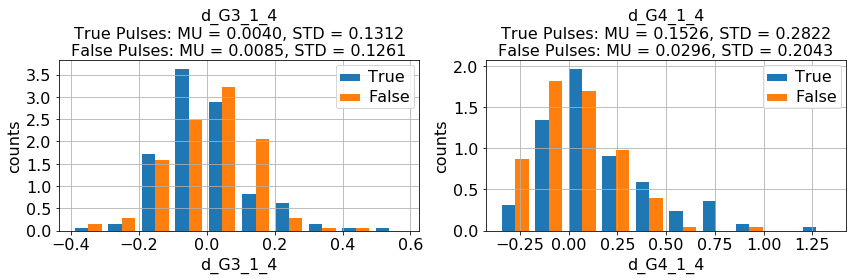

In [17]:
# distribution of G3 and G4 responses to odor

metrics = pd.read_csv(os.path.join(SAVE_DIR, '{}_METRICS.csv'.format(EXPT)), index_col=0)
metrics_ctl = pd.read_csv(
    os.path.join(SAVE_DIR, '{}_METRICS_FALSE_ODOR_OFFSET_-30.csv'.format(EXPT)), index_col=0)

fig, axs = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)

for ax, k in zip(axs, ['d_G3_1_4', 'd_G4_1_4']):
    
    ax.hist(np.array([metrics[k], metrics_ctl[k]]).T, normed=True)
    ax.set_xlabel(k)
    ax.set_ylabel('counts')
    ax.set_title('{4}\nTrue Pulses: MU = {0:.4f}, STD = {1:.4f}\nFalse Pulses: MU = {2:.4f}, STD = {3:.4f}'.format(
        np.nanmean(metrics[k]), np.nanstd(metrics[k]),
        np.nanmean(metrics_ctl[k]), np.nanstd(metrics_ctl[k]), k))
    ax.legend(['True', 'False'])


for ax in axs:
    ax.grid()
    set_font_size(ax, 16)